#### <b>Load Required Libraries</b>

In [1]:
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import math
import os
import random

from types import SimpleNamespace
from scipy.fftpack import dct, idct

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80
plt.rcParams.update({'font.size': 12})

### <b>Dataset Download</b>

* This gender classification dataset has total <b>58,658 images</b>. (train: 47,009 / val: 11,649)
* <b>Dataset</b>: [Kaggle Gender Classification Dataset](https://www.kaggle.com/cashutosh/gender-classification-dataset)

<pre>
<b>Dataset</b>/
    <b>Training</b>/
        <b>female</b>/
          23,243 images
        <b>male</b>/
          23,766 images
    <b>Validation</b>/
        <b>female</b>/
          5,841 images
        <b>male</b>/
          5,808 images
</pre>


In [3]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EdWfjq2Cu49Bv6xnZ4FHeswBZSrbikXZqPdLrP8pFhwfQQ?download=1 -O gender_classification_dataset.zip
!unzip gender_classification_dataset.zip -d ./gender_classification_dataset

In [4]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_dir = './gender_classification_dataset'
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Validation'), transforms_val)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=128, shuffle=True, num_workers=4)
print('Validation dataset size:', len(val_datasets))

class_names = val_datasets.classes
print('Class names:', class_names)

Validation dataset size: 11649
Class names: ['female', 'male']


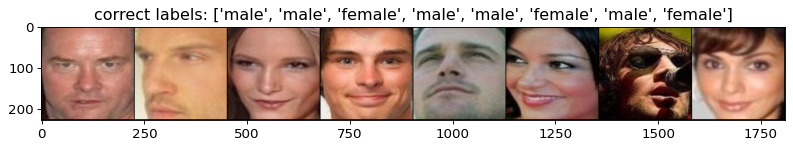

In [13]:
# display a torch image
def imshow(inputs, classes, message):
    inputs_data = inputs
    classes_data = classes
    if inputs.shape[0] > 8: # display maximum 4 images
        inputs_data = inputs[:8]
        classes_data = classes[:8]
    inputs_data = torchvision.utils.make_grid(inputs_data)
    # torch.Tensor => numpy
    inputs_data = inputs_data.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(inputs_data)
    plt.title(message + ': ' + str([class_names[x] for x in classes_data]))
    plt.show()


# visualize a batch of validation image
iterator = iter(val_dataloader)
inputs, classes = next(iterator)
imshow(inputs, classes, 'correct labels')

### <b>Load Pre-trained Classification Model</b>

* Set the model to the evaluation mode.

In [6]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1 -O classification_model.pth

--2021-03-03 00:03:14--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 40.108.156.33
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|40.108.156.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/face_gender_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVmQ5YkZXenF6dE1yWFJEZE5uQ0hRa0JzSGFNNG41XzFxMWZ1ZTc3dnRRVnR3P3J0aW1lPUNNaEp2dGZkMkVn [following]
--2021-03-03 00:03:15--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/face_gender_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmN

In [14]:
save_path = 'classification_model.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model = model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

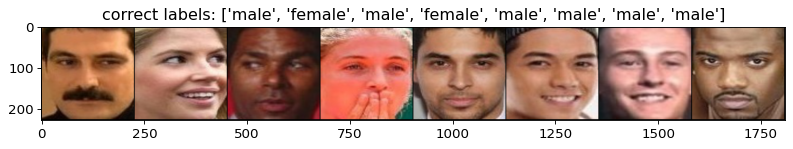

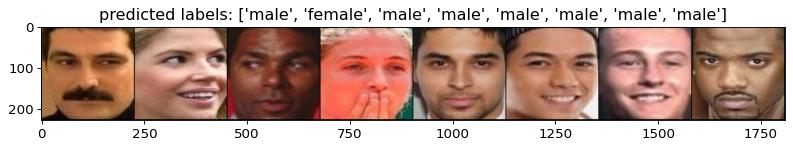

In [17]:
# visualize a batch of validation image
iterator = iter(val_dataloader)
inputs, classes = next(iterator)
imshow(inputs, classes, 'correct labels')

# visualize a prediction result
preds, _ = get_preds(model, inputs.cuda(), batch_size=8, return_cpu=False)
imshow(inputs, preds, 'predicted labels')

#### <b>Define Utilities</b>

In [8]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


# applies the normalization transformations
def apply_normalization(imgs):
    imgs_tensor = imgs.clone()
    if imgs.dim() == 3: # color image
        for i in range(imgs_tensor.size(0)):
            imgs_tensor[i, :, :] = (imgs_tensor[i, :, :] - MEAN[i]) / STD[i]
    else: # grayscale image
        for i in range(imgs_tensor.size(1)):
            imgs_tensor[:, i, :, :] = (imgs_tensor[:, i, :, :] - MEAN[i]) / STD[i]
    return imgs_tensor


# get prediction outputs
def get_preds(model, inputs, batch_size, return_cpu=True):
    num_batches = int(math.ceil(inputs.size(0) / float(batch_size)))
    all_preds, all_probs = None, None
    for i in range(num_batches):
        upper = min((i + 1) * batch_size, inputs.size(0))
        input = apply_normalization(inputs[(i * batch_size):upper])
        with torch.no_grad():
            output = torch.nn.Softmax(dim=1)(model.forward(input.cuda()))
        prob, pred = output.max(1)
        if return_cpu:
            prob = prob.data.cpu()
            pred = pred.data.cpu()
        else:
            prob = prob.data
            pred = pred.data
        if i == 0:
            all_probs = prob
            all_preds = pred
        else:
            all_probs = torch.cat((all_probs, prob), 0)
            all_preds = torch.cat((all_preds, pred), 0)
    return all_preds, all_probs


# get low frequency noises
def sample_gaussian_torch(image_size, dct_ratio=1.0):
    x = torch.zeros(image_size)
    fill_size = int(image_size[-1] * dct_ratio)
    x[:, :, :fill_size, :fill_size] = torch.randn(x.size(0), x.size(1), fill_size, fill_size)
    if dct_ratio < 1.0:
        x = torch.from_numpy(idct(idct(x.numpy(), axis=3, norm='ortho'), axis=2, norm='ortho'))
    return x

#### <b>Boundary Attack Functions</b>

In [9]:
def boundary_attack(
    model, images, labels, init=None, max_iters=1000,
    spherical_step=0.01, source_step=0.01, step_adaptation=1.5, reset_step_every=50,
    dct_mode=True, dct_ratio=1.0):


    images = images.cuda()
    labels = labels.cuda()
    batch_size = images.size(0)
    base_preds, _ = get_preds(model, images.cuda(), batch_size=batch_size, return_cpu=False)
    images_vec = images.view(batch_size, -1)
    imshow(images.cpu(), labels, 'original labels')


    """ Prepare initial images """
    iterator = iter(val_dataloader)
    init = torch.zeros(images.size()).cuda()
    preds = labels.clone()
    while preds.eq(labels).sum() > 0:
        print("Sampling initial images")
        idx = torch.arange(0, batch_size).long().cuda()[preds.eq(labels)]
        rand_image, _ = next(iterator)
        init[idx] = rand_image[idx].cuda()
        preds, _ = get_preds(model, init, batch_size=batch_size, return_cpu=False)
    preds, _ = get_preds(model, init, batch_size=batch_size, return_cpu=False)
    perturbed = init.clone()
    print('[Initial adversairal examples]')
    imshow(perturbed.cpu(), preds, 'predicted labels')


    """ Prepare Start Points """
    min_alpha = torch.zeros(batch_size).cuda()
    max_alpha = torch.ones(batch_size).cuda()
    for _ in range(10): # binary search
        alpha = (min_alpha + max_alpha) / 2
        alpha_expanded = alpha.view(batch_size, 1, 1, 1).expand_as(init)
        interp = alpha_expanded * init + (1 - alpha_expanded) * images
        preds, _ = get_preds(model, interp, batch_size=batch_size, return_cpu=False)
        min_alpha[preds.eq(labels)] = alpha[preds.eq(labels)]
        max_alpha[preds.ne(labels)] = alpha[preds.ne(labels)]
        perturbed[preds.ne(labels)] = interp[preds.ne(labels)] # untargeted attack (label should be not equal)
    print('[Start points]')
    preds, _ = get_preds(model, perturbed, batch_size=batch_size, return_cpu=False)
    imshow(perturbed.cpu(), preds, 'predicted labels')


    """ Attack Start """
    # recording success rate of previous moves for adjusting step size
    spherical_succ = torch.zeros(batch_size, reset_step_every).cuda()
    source_succ = torch.zeros(batch_size, reset_step_every).cuda()
    spherical_steps = (torch.ones(batch_size) * spherical_step).cuda()
    source_steps = (torch.ones(batch_size) * source_step).cuda()
    
    for i in range(max_iters):
        candidates, spherical_candidates = generate_candidate(
            images, perturbed, spherical_steps, source_steps, dct_mode=dct_mode, dct_ratio=dct_ratio)
        # additional query on spherical candidate for RGB-BA
        if not dct_mode: 
            spherical_preds, _ = get_preds(model, spherical_candidates, batch_size=batch_size, return_cpu=False)
        else:
            spherical_preds = labels + 1 # Make the spherical success rate = 100%
        source_preds, _ = get_preds(model, candidates, batch_size=batch_size, return_cpu=False)
        spherical_succ[:, i % reset_step_every][spherical_preds.ne(labels)] = 1
        source_succ[:, i % reset_step_every][source_preds.ne(labels)] = 1

        # reject moves if they result incorrectly classified images
        idx = torch.arange(0, batch_size).long().cuda()[source_preds.eq(labels)] # attack fail indexes
        candidates[idx] = perturbed[idx] # then, reject
        # reject moves if MSE is already low enough
        if i > 0:
            candidates[mse_prev.lt(1e-6)] = perturbed[mse_prev.lt(1e-6)]
  
        # record current stats
        perturbed_vec = perturbed.view(batch_size, -1)
        candidates_vec = candidates.view(batch_size, -1)
        mse_prev = (images_vec - perturbed_vec).pow(2).mean(1)
        mse = (images_vec - candidates_vec).pow(2).mean(1)
        reduction = 100 * (mse_prev.mean() - mse.mean()) / mse_prev.mean()
        norms = (images_vec - candidates_vec).norm(2, 1)
        print('Iteration %d:  MSE = %.6f (reduced by %.4f%%), L2 norm = %.4f' % (i + 1, mse.mean(), reduction, norms.mean()))
        
        # adjust step size
        if (i + 1) % reset_step_every == 0:
            spherical_steps, source_steps, p_spherical, p_source = adjust_step(spherical_succ, source_succ, spherical_steps, source_steps, step_adaptation, dct_mode=dct_mode)
            spherical_succ.fill_(0)
            source_succ.fill_(0)
            print('Spherical success rate = %.4f, new spherical step = %.4f' % (p_spherical.mean(), spherical_steps.mean()))
            print('Source success rate = %.4f, new source step = %.4f' % (p_source.mean(), source_steps.mean()))

        perturbed = candidates
            
    return perturbed.cpu()
        
    
def generate_candidate(images, perturbed, spherical_steps, source_steps, dct_mode='none', dct_ratio=1.0):
    batch_size = images.size(0)
    unnormalized_source_direction = images - perturbed
    source_norm = unnormalized_source_direction.view(batch_size, -1).norm(2, 1)
    source_direction = unnormalized_source_direction.div(source_norm.view(batch_size, 1, 1, 1).expand_as(unnormalized_source_direction))
    
    perturbation = sample_gaussian_torch(images.size(), dct_ratio=dct_ratio)
    perturbation = perturbation.cuda()
    
    if not dct_mode:
        dot = (images * perturbation).view(batch_size, -1).sum(1)
        perturbation -= source_direction.mul(dot.view(batch_size, 1, 1, 1).expand_as(source_direction))
    alpha = spherical_steps * source_norm / perturbation.view(batch_size, -1).norm(2, 1)
    perturbation = perturbation.mul(alpha.view(batch_size, 1, 1, 1).expand_as(perturbation))
    if not dct_mode:
        D = spherical_steps.pow(2).add(1).pow(-0.5)
        direction = perturbation - unnormalized_source_direction
        spherical_candidates = (images + direction.mul(D.view(batch_size, 1, 1, 1).expand_as(direction)))
    else:
        spherical_candidates = perturbed + perturbation
    spherical_candidates = spherical_candidates.clamp(0, 1)
    
    new_source_direction = images - spherical_candidates
    new_source_direction_norm = new_source_direction.view(batch_size, -1).norm(2, 1)
    length = source_steps * source_norm
    deviation = new_source_direction_norm - source_norm
    length += deviation
    length[length.le(0)] = 0
    length = length / new_source_direction_norm
    candidates = (spherical_candidates + new_source_direction.mul(length.view(batch_size, 1, 1, 1).expand_as(new_source_direction)))
    candidates = candidates.clamp(0, 1)
    
    return (candidates, spherical_candidates)


def adjust_step(spherical_succ, source_succ, spherical_steps, source_steps, step_adaptation, dct_mode='none'):
    p_spherical = spherical_succ.mean(1)
    num_spherical = spherical_succ.sum(1)
    p_source = torch.zeros(source_succ.size(0)).cuda()
    for i in range(source_succ.size(0)):
        if num_spherical[i] == 0:
            p_source[i] = 0
        else:
            p_source[i] = source_succ[i, :][spherical_succ[i].eq(1)].mean()
    if not dct_mode:
        # adjust spherical steps when using RGB-BA
        spherical_steps[p_spherical.lt(0.2)] = spherical_steps[p_spherical.lt(0.2)] / step_adaptation
        spherical_steps[p_spherical.gt(0.6)] = spherical_steps[p_spherical.gt(0.6)] * step_adaptation
    source_steps[num_spherical.ge(10) * p_source.lt(0.2)] = source_steps[num_spherical.ge(10) * p_source.lt(0.2)] / step_adaptation
    source_steps[num_spherical.ge(10) * p_source.gt(0.6)] = source_steps[num_spherical.ge(10) * p_source.gt(0.6)] * step_adaptation
    return (spherical_steps, source_steps, p_spherical, p_source)

#### <b>Run Attack</b>

[Attack start]


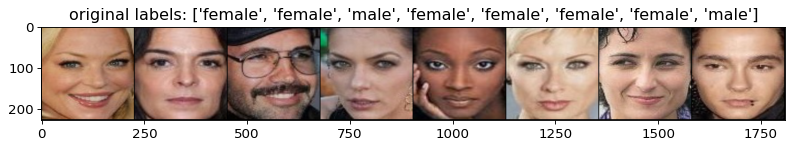

Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
[Initial adversairal examples]


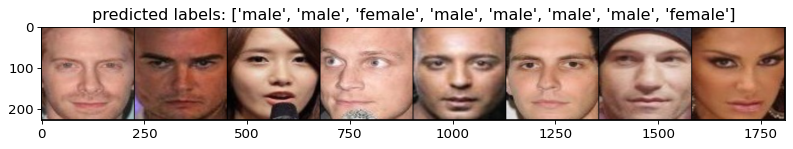

[Start points]


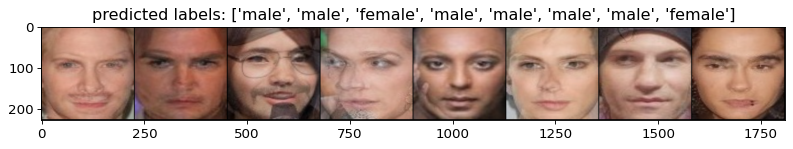

Iteration 1:  MSE = 0.020775 (reduced by 0.1229%), L2 norm = 51.0421
Iteration 2:  MSE = 0.020775 (reduced by 0.0000%), L2 norm = 51.0421
Iteration 3:  MSE = 0.020755 (reduced by 0.0976%), L2 norm = 51.0205
Iteration 4:  MSE = 0.020747 (reduced by 0.0360%), L2 norm = 51.0133
Iteration 5:  MSE = 0.020723 (reduced by 0.1171%), L2 norm = 50.9863
Iteration 6:  MSE = 0.020714 (reduced by 0.0446%), L2 norm = 50.9755
Iteration 7:  MSE = 0.020692 (reduced by 0.1055%), L2 norm = 50.9559
Iteration 8:  MSE = 0.020669 (reduced by 0.1083%), L2 norm = 50.9320
Iteration 9:  MSE = 0.020648 (reduced by 0.1039%), L2 norm = 50.9112
Iteration 10:  MSE = 0.020631 (reduced by 0.0811%), L2 norm = 50.8933
Iteration 11:  MSE = 0.020629 (reduced by 0.0105%), L2 norm = 50.8871
Iteration 12:  MSE = 0.020627 (reduced by 0.0072%), L2 norm = 50.8837
Iteration 13:  MSE = 0.020626 (reduced by 0.0087%), L2 norm = 50.8789
Iteration 14:  MSE = 0.020621 (reduced by 0.0232%), L2 norm = 50.8700
Iteration 15:  MSE = 0.020594

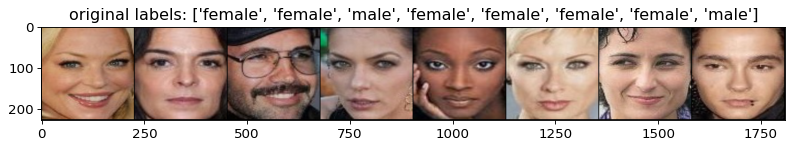

[Attack result examples]


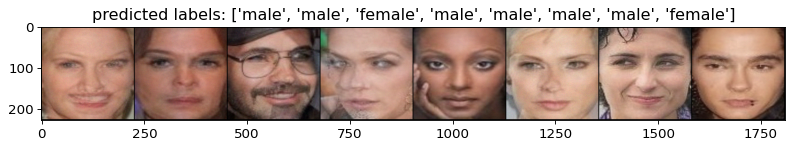

In [11]:
args = SimpleNamespace()
args.data_root = './gender_classification_dataset' # the root directory of a dataset
args.num_runs = 128 # number of repeated runs (number of images)
args.batch_size = 128 # batch size for parallel runs
args.num_steps = 1500 # maximum number of iterations (number of queries)
args.perturb_mode = 'gaussian' # type of spherical perturbation sample (gaussian / dct)
args.spherical_step = 0.01 # spherical step size
args.source_step = 0.01 # source step size
args.dct_ratio = 1.0 # ratio of nonzero frequencies for dct

dct_mode = (args.perturb_mode == 'dct')

# load previously sampled set of images
testset = datasets.ImageFolder(args.data_root + '/Validation', transforms_val)
images = torch.zeros(args.num_runs, 3, 224, 224)
labels = torch.zeros(args.num_runs).long()
preds = labels + 1

# sample a new set of images that are correctly classified
while preds.ne(labels).sum() > 0:
    idx = torch.arange(0, images.size(0)).long()[preds.ne(labels)]
    for i in list(idx):
        images[i], labels[i] = testset[random.randint(0, len(testset) - 1)] # you can apply fixed seed
    preds[idx], _ = get_preds(model, images[idx], batch_size=args.batch_size)

# start attack
N = int(math.floor(float(args.num_runs) / float(args.batch_size)))
for i in range(N):
    print("==============================================================")
    print('[Attack start]')
    upper = min((i + 1) * args.batch_size, args.num_runs)
    images_batch = images[(i * args.batch_size):upper]
    labels_batch = labels[(i * args.batch_size):upper]
    perturbed = boundary_attack(
        model, images_batch, labels_batch, max_iters=args.num_steps,
        spherical_step=args.spherical_step, source_step=args.source_step,
        dct_mode=dct_mode, dct_ratio=args.dct_ratio)

    print('[Original examples]')
    imshow(images_batch.cpu(), labels_batch, 'original labels')

    preds, _ = get_preds(model, perturbed, batch_size=args.batch_size, return_cpu=False)
    print('[Attack result examples]')
    imshow(perturbed.cpu(), preds, 'predicted labels')

[Attack start]


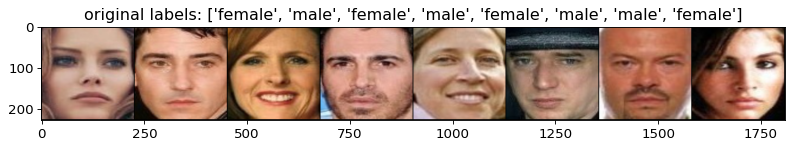

Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
[Initial adversairal examples]


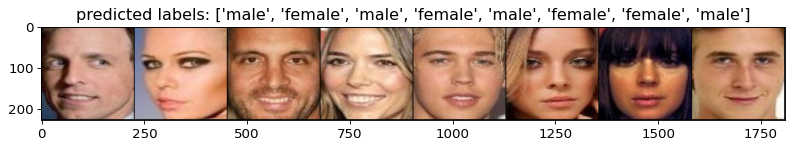

[Start points]


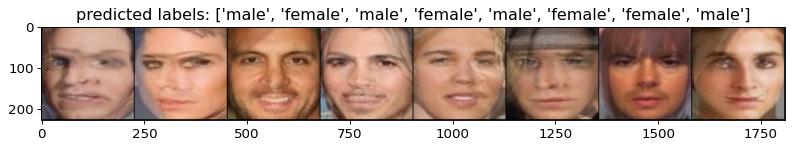

Iteration 1:  MSE = 0.019329 (reduced by 0.6131%), L2 norm = 50.0114
Iteration 2:  MSE = 0.019203 (reduced by 0.6527%), L2 norm = 49.8603
Iteration 3:  MSE = 0.019075 (reduced by 0.6650%), L2 norm = 49.7026
Iteration 4:  MSE = 0.018962 (reduced by 0.5939%), L2 norm = 49.5592
Iteration 5:  MSE = 0.018842 (reduced by 0.6332%), L2 norm = 49.4013
Iteration 6:  MSE = 0.018742 (reduced by 0.5328%), L2 norm = 49.2650
Iteration 7:  MSE = 0.018643 (reduced by 0.5293%), L2 norm = 49.1386
Iteration 8:  MSE = 0.018546 (reduced by 0.5200%), L2 norm = 49.0201
Iteration 9:  MSE = 0.018421 (reduced by 0.6740%), L2 norm = 48.8660
Iteration 10:  MSE = 0.018324 (reduced by 0.5266%), L2 norm = 48.7316
Iteration 11:  MSE = 0.018215 (reduced by 0.5924%), L2 norm = 48.5936
Iteration 12:  MSE = 0.018117 (reduced by 0.5409%), L2 norm = 48.4643
Iteration 13:  MSE = 0.018027 (reduced by 0.4929%), L2 norm = 48.3491
Iteration 14:  MSE = 0.017941 (reduced by 0.4805%), L2 norm = 48.2288
Iteration 15:  MSE = 0.017852

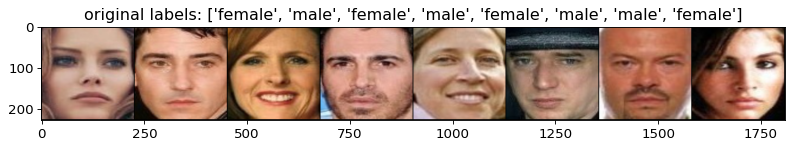

[Attack result examples]


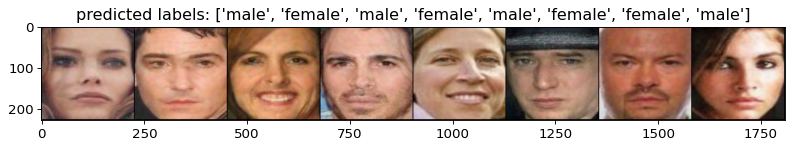

In [18]:
args = SimpleNamespace()
args.data_root = './gender_classification_dataset' # the root directory of a dataset
args.num_runs = 128 # number of repeated runs (number of images)
args.batch_size = 128 # batch size for parallel runs
args.num_steps = 1500 # maximum number of iterations (number of queries)
args.perturb_mode = 'dct' # type of spherical perturbation sample (gaussian / dct)
args.spherical_step = 0.01 # spherical step size
args.source_step = 0.01 # source step size
args.dct_ratio = 0.125 # ratio of nonzero frequencies for dct

dct_mode = (args.perturb_mode == 'dct')

# load previously sampled set of images
testset = datasets.ImageFolder(args.data_root + '/Validation', transforms_val)
images = torch.zeros(args.num_runs, 3, 224, 224)
labels = torch.zeros(args.num_runs).long()
preds = labels + 1

# sample a new set of images that are correctly classified
while preds.ne(labels).sum() > 0:
    idx = torch.arange(0, images.size(0)).long()[preds.ne(labels)]
    for i in list(idx):
        images[i], labels[i] = testset[random.randint(0, len(testset) - 1)] # you can apply fixed seed
    preds[idx], _ = get_preds(model, images[idx], batch_size=args.batch_size)

# start attack
N = int(math.floor(float(args.num_runs) / float(args.batch_size)))
for i in range(N):
    print("==============================================================")
    print('[Attack start]')
    upper = min((i + 1) * args.batch_size, args.num_runs)
    images_batch = images[(i * args.batch_size):upper]
    labels_batch = labels[(i * args.batch_size):upper]
    perturbed = boundary_attack(
        model, images_batch, labels_batch, max_iters=args.num_steps,
        spherical_step=args.spherical_step, source_step=args.source_step,
        dct_mode=dct_mode, dct_ratio=args.dct_ratio)

    print('[Original examples]')
    imshow(images_batch.cpu(), labels_batch, 'original labels')

    preds, _ = get_preds(model, perturbed, batch_size=8, return_cpu=False)
    print('[Attack result examples]')
    imshow(perturbed.cpu(), preds, 'predicted labels')